# k-means clustering

Attempt to predict the interest rate charged to a group/cluster of loans.

Start by examining the clustering in the data.

Only need accepted loans for this.

In [3]:
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pylab as pl

%pylab inline

data_directory = os.path.join('.', 'cleaned_data') 

cleaned_accepted_data_path = os.path.join(data_directory, 'Cleaned_AcceptedLoanData.csv')

Populating the interactive namespace from numpy and matplotlib


In [4]:
accepted_df = pd.read_csv(cleaned_accepted_data_path, low_memory=False, encoding='UTF-8')

# Temporarily sample until we have an idea of how long this will take.
accepted_df = accepted_df.sample(n=100000)

# There's a row with an income of 4.3m that is badly skewing the results, so remove it for now.
accepted_df = accepted_df[accepted_df.annual_inc < 1000000]

print(accepted_df.info())

# Remove non-numeric columns and those we don't care about.
accepted_df.drop(['Unnamed: 0', 'purpose', 'issue_d', 'fico_range', 'last_fico_range', 'timestamp'], 
                 axis=1, inplace=True)

# Remove the interest rate, since we're going to try and predict that from the clustering.
accepted_df.drop(['int_rate'], axis=1, inplace=True)

# Replace the string 'term' with a number.
accepted_df['term'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
accepted_df['term'] = accepted_df['term'].astype(int)

# Split home ownership values into separate variables:
# home_mortgage, home_rent and home_own.
accepted_df['home_mortgage'] = 0
accepted_df['home_rent'] = 0
accepted_df['home_own'] = 0

accepted_df.loc[accepted_df['home_ownership']=='MORTGAGE', 'home_mortgage'] = 1
accepted_df.loc[accepted_df['home_ownership']=='RENT', 'home_rent'] = 1
accepted_df.loc[accepted_df['home_ownership']=='OWN', 'home_own'] = 1

# Drop home_ownership now.
accepted_df.drop(['home_ownership'], axis=1, inplace=True)

# Split application_type into separate variables: individual (0/1)
accepted_df['individual'] = 0
accepted_df.loc[accepted_df['application_type']=='INDIVIDUAL', 'individual'] = 1

# Drop application_type now.
accepted_df.drop(['application_type'], axis=1, inplace=True)

# Turn verification status into a numeric column.
accepted_df['income_verified'] = 1
accepted_df.loc[accepted_df['verification_status']=='Not Verified', 'income_verified'] = 0

# Drop verification status now.
accepted_df.drop(['verification_status', 'verification_status_joint'], axis=1, inplace=True)

# Drop the current credit score, since it wasn't available at the time the interest rate was set.
accepted_df.drop(['last_mean_fico'], axis=1, inplace=True)

print(accepted_df.info())
accepted_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99977 entries, 6125 to 61365
Data columns (total 34 columns):
Unnamed: 0                    99977 non-null int64
loan_amnt                     99977 non-null float64
term                          99977 non-null object
int_rate                      99977 non-null float64
emp_length                    99977 non-null float64
home_ownership                99977 non-null object
annual_inc                    99977 non-null float64
verification_status           99977 non-null object
issue_d                       99977 non-null object
purpose                       99977 non-null object
dti                           99977 non-null float64
delinq_2yrs                   99977 non-null float64
earliest_cr_line              99977 non-null int64
inq_last_6mths                99977 non-null float64
mths_since_last_delinq        99977 non-null float64
pub_rec                       99977 non-null float64
revol_bal                     99977 non-null floa

,loan_amnt,term,emp_length,annual_inc,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,pub_rec,...,chargeoff_within_12_mths,delinq_amnt,mort_acc,pct_tl_nvr_dlq,mean_fico,home_mortgage,home_rent,home_own,individual,income_verified
count,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000,...,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000
mean,14791.204477,42.885024,5.778009,76658.638598,18.239221,0.329722,18.640437,0.659785,33.857949,0.218001,...,0.009213,11.841143,1.691042,94.089455,697.107740,0.494584,0.398122,0.107125,0.993118,0.694240
std,8651.479162,10.853910,3.725075,50567.416370,8.293517,0.889187,7.564103,0.971696,15.448210,0.671265,...,0.113878,671.674031,1.970228,8.499494,30.747058,0.499973,0.489513,0.309273,0.082670,0.460731
min,900.000000,36.000000,0.000000,5400.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,15.400000,622.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8000.000000,36.000000,2.000000,46507.500000,12.050000,0.000000,13.000000,0.000000,30.000000,0.000000,...,0.000000,0.000000,0.000000,91.700000,672.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,13000.000000,36.000000,6.000000,65000.000000,17.770000,0.000000,17.000000,0.000000,33.849096,0.000000,...,0.000000,0.000000,1.000000,97.000000,692.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,20000.000000,60.000000,10.000000,92000.000000,24.110000,0.000000,23.000000,1.000000,33.849096,0.000000,...,0.000000,0.000000,3.000000,100.000000,712.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,40000.000000,60.000000,10.000000,990000.000000,46.520000,21.000000,66.000000,32.000000,168.000000,86.000000,...,7.000000,97619.000000,32.000000,100.000000,847.500000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
##### cluster data into K=1..10 clusters #####
#K, KM, centroids, D_k, cIdx, dist, avgWithinSS = kmeans.run_kmeans(X,10)

K = range(1,10)

# scipy.cluster.vq.kmeans
KM = [kmeans(accepted_df, k) for k in K] # apply kmeans 1 to 10
centroids = [cent for (cent, var) in KM]   # cluster centroids

D_k = [cdist(accepted_df, cent, 'euclidean') for cent in centroids]

cIdx = [np.argmin(D, axis=1) for D in D_k]
dist = [np.min(D, axis=1) for D in D_k]
avgWithinSS = [sum(d) / accepted_df.shape[0] for d in dist]

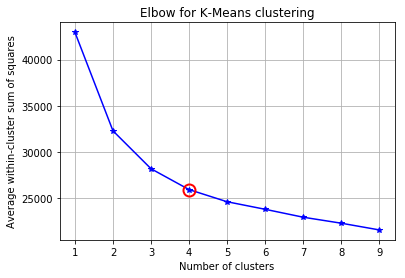

In [6]:
kIdx = 3

# plot elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Elbow for K-Means clustering')

In [7]:
km = KMeans(4, init='k-means++') # initialize
km.fit(accepted_df)
accepted_df['cluster'] = km.predict(accepted_df) # classify into clusters

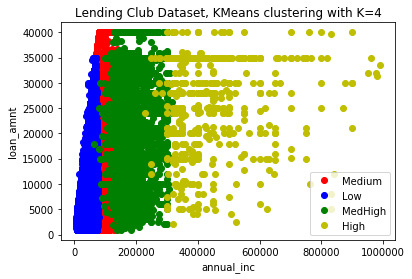

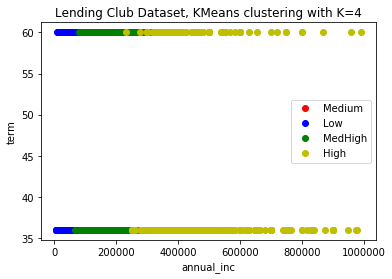

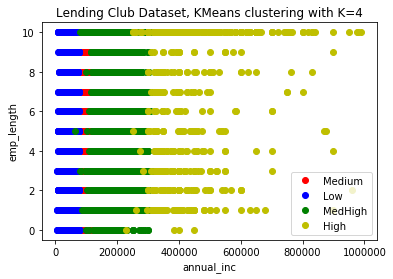

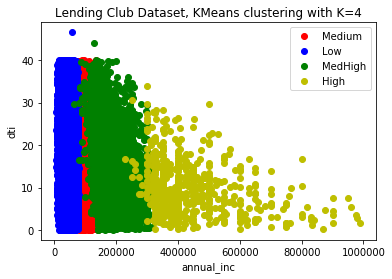

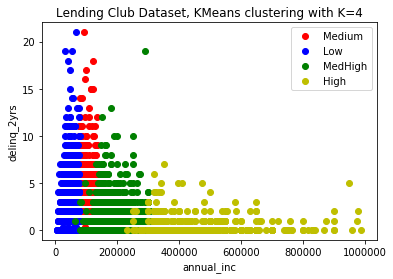

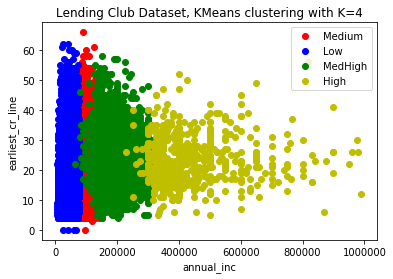

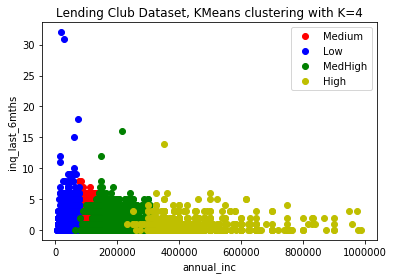

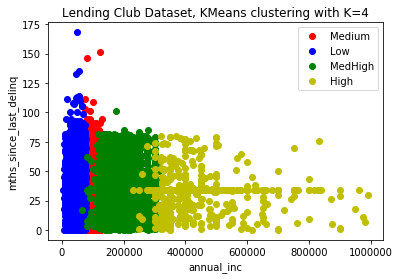

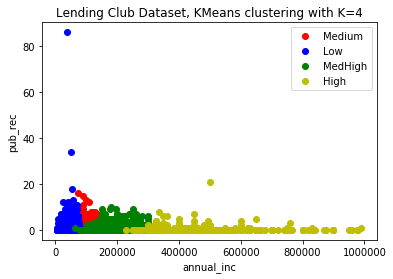

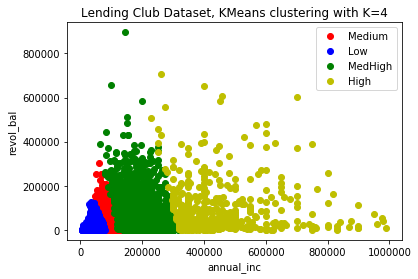

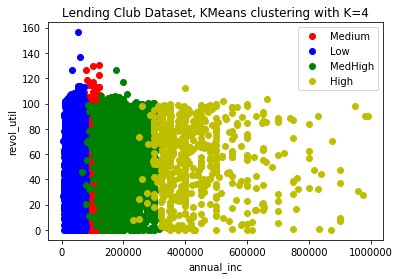

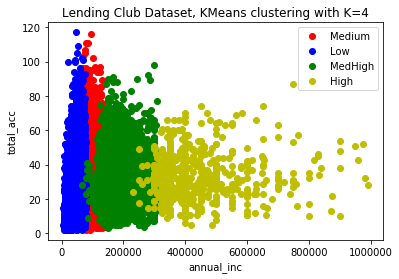

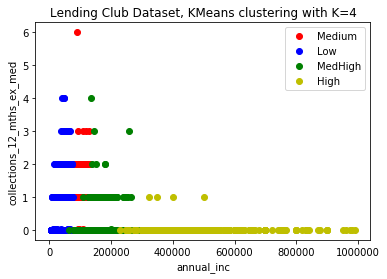

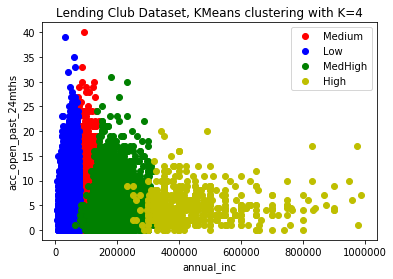

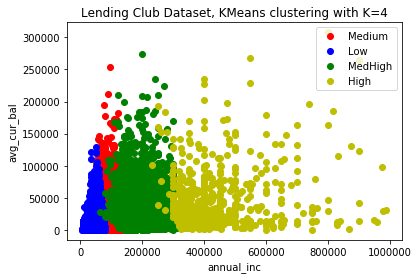

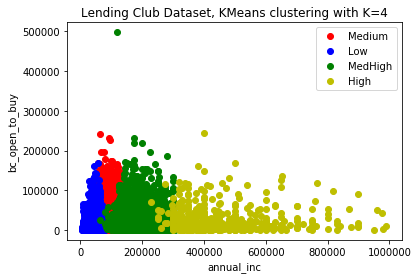

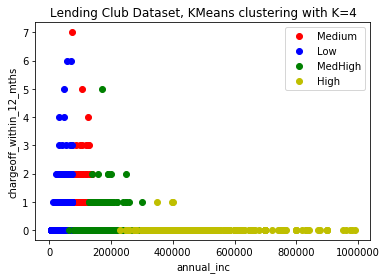

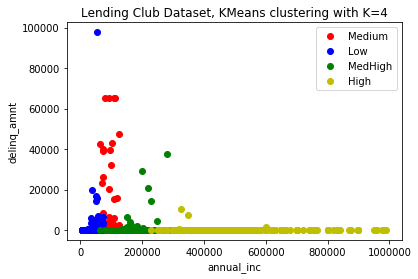

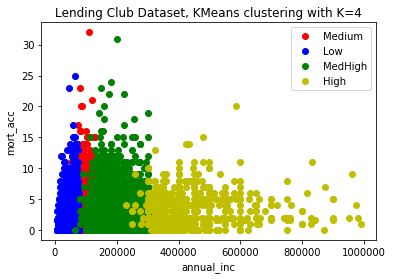

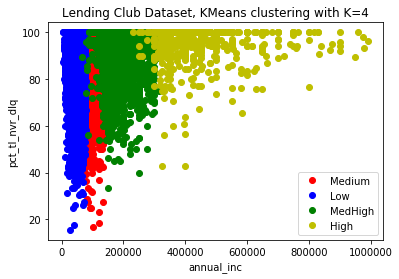

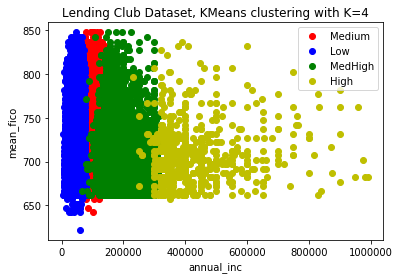

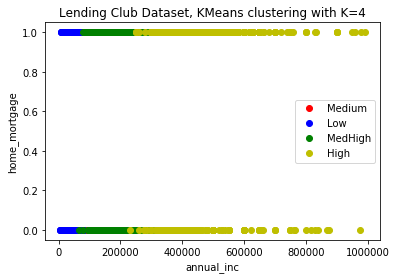

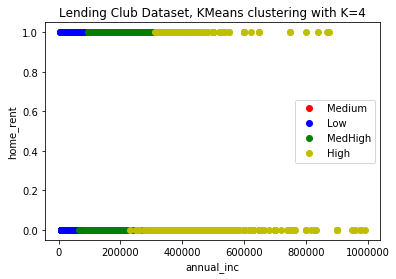

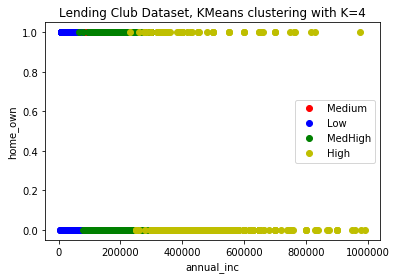

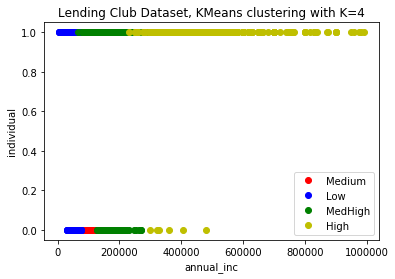

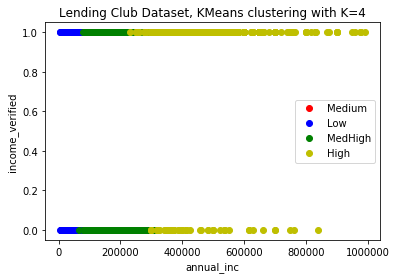

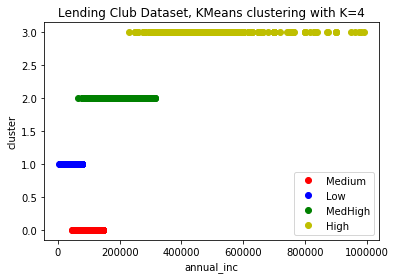

In [9]:
def plot_clusters(orig, pred, nx, ny, labels, legend=True):
    data = orig
 
    # plot data into three clusters based on value of c
    p0 = plt.plot(data[pred==0,nx], data[pred==0,ny], 'ro', label='Medium')
    p1 = plt.plot(data[pred==1,nx], data[pred==1,ny], 'bo', label='Low') 
    p2 = plt.plot(data[pred==2,nx], data[pred==2,ny], 'go', label='MedHigh') 
    p3 = plt.plot(data[pred==3,nx], data[pred==3,ny], 'yo', label='High') 


    lx = p1[0].axes.set_xlabel(labels[nx])
    ly = p1[0].axes.set_ylabel(labels[ny])
    tt= plt.title('Lending Club Dataset, KMeans clustering with K=4')
    
    if legend:
        ll=plt.legend()  
  
    plt.show()
    return (p0,p1,p2,p3)


for i in range(0,accepted_df.shape[1]):
    if i != 3:
        (pl0, pl1, pl2, pl3) = plot_clusters(accepted_df.values, accepted_df['cluster'].values, 
                                             3, i, accepted_df.columns) 